In [128]:
from tqdm.notebook import tqdm
%run infectionspread.py

In [4]:
outbreak_list = []
finalsize_list = []
iterations = 5000
for iter in range(iterations):

    outbreak = run_outbreak(1,10)
    #Iter will be one too long thanks to while loops

    #Bit of exploratory plotting:
    df = pd.DataFrame({
        "generation": pd.Series(range(len(outbreak))),
        "infections": pd.Series( (x["next_generation_infections"] for x in outbreak)),
        "iteration": iter,
        "infection_days": pd.Series( (x["infection_days"] for x in outbreak)),
        "infection_times": (x["infection_times"] for x in outbreak)
    })

    finalsize = pd.DataFrame({
        "iteration": iter,
        "finalsize": sum(df["infections"])
    }, index=[iter])

    outbreak_list.append(df)
    finalsize_list.append(finalsize)

combined_outbreaks = pd.concat(outbreak_list)
finalsize = pd.concat(finalsize_list)

finalsize
0       0.4598
1       0.1084
2       0.0480
3       0.0312
4       0.0186
         ...  
1730    0.0002
1734    0.0002
1867    0.0002
1964    0.0002
2473    0.0002
Length: 595, dtype: float64
45.98% of simulations had no cases
27.94% of simulations had more than 10 cases
Average of 2.4969 infection days (95% CI [0.  5.5] )


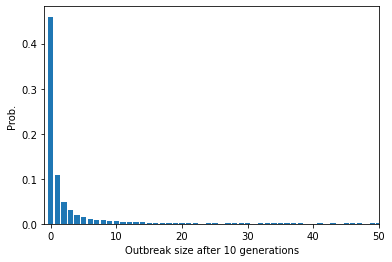

In [5]:
%matplotlib inline
groups = combined_outbreaks.groupby("iteration")

#Traces of outbreaks:
#for name, group in groups:
#    plt.plot(group["generation"], group["infections"], label=name)
#print(finalsize)
tab = finalsize.groupby("finalsize").size()/iterations
print(tab)
fig = plt.figure()
#plt.plot(np.delete(tab.index.values, [0]), tab.drop(0))
plt.bar(tab.index.values, tab)
plt.xlabel("Outbreak size after 10 generations")
plt.ylabel("Prob.")
plt.xlim(left=-1,right=50)

print(round(sum(tab[tab.index.values == 0]*100), 2), "% of simulations had no cases", sep="")
print(round(sum(tab[tab.index.values > 10]*100), 2), "% of simulations had more than 10 cases", sep="")

generation_zero_infectiondays = combined_outbreaks[combined_outbreaks["generation"] == 0]["infection_days"]
print("Average of", np.mean(generation_zero_infectiondays), "infection days (95% CI", np.quantile(generation_zero_infectiondays, [0.025, 0.975]), ")")


There is 1258 iterations with at least 20 cases.
Average of 22.11 days to reach 20 cases.


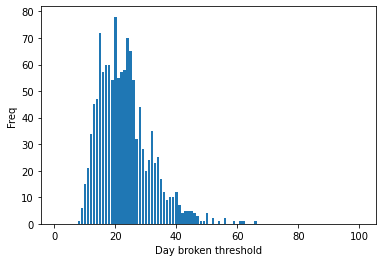

In [6]:
#Time at which 20 total cases is reached:
case_threshold = 20
iters_with_enough_cases = finalsize["iteration"][finalsize["finalsize"] > case_threshold]
print("There is", len(iters_with_enough_cases), "iterations with at least", case_threshold, "cases.")
day_broken_threshold = np.zeros(100)
for iter in iters_with_enough_cases:
    infection_times = pd.Series(combined_outbreaks[combined_outbreaks["iteration"] == iter]["infection_times"]).explode().dropna()
    for day in range(100):
        if sum(infection_times < day) >= case_threshold:
            day_broken_threshold[day] += 1
            break

fig_daythreshold = plt.figure()
plt.bar([x+1 for x in range(100)], height=day_broken_threshold)
plt.xlabel("Day broken threshold")
plt.ylabel("Freq")

day_broken_threshold_probs = day_broken_threshold / sum(day_broken_threshold)
mean = 0
for day in range(len(day_broken_threshold)):
    mean += day *day_broken_threshold_probs[day]
print("Average of", round(mean, 2), "days to reach", case_threshold, "cases.")

In [54]:
#Critical number of seedings:
def get_seedings(in_isolation, max_infected=50, max_seed_infected=30, iterations=10000, transmission_potential_mean=1.3):
    died_out = np.zeros([max_seed_infected, max_infected+2])
    num_generations = np.zeros([max_seed_infected, 1000])
    categories = np.zeros([max_seed_infected, 3])
    infection_days = np.zeros([max_seed_infected, iterations])
    for initial_infected in tqdm(range(max_seed_infected)):
        
        for iter in range(iterations):
            #Range starts at 0:
            generation_zero_times = np.random.uniform(0, 12*7, size = initial_infected)
            outbreak = run_outbreak(initial_infected, 2*max_infected, generation_zero_times, in_isolation=in_isolation, max_infections = max_infected, transmission_potential_mean = transmission_potential_mean)
            finalsize = get_finalsize(outbreak)
            if finalsize > max_infected:
                finalsize = max_infected
            died_out[int(initial_infected)][int(finalsize)] += 1
            num_generations[int(initial_infected)][len(outbreak)] += 1
            infection_days[int(initial_infected)][iter] = outbreak[0]["infection_days"]

            #Category Green: No outbreak (i.e. 1 generation)
            if finalsize == 0:
                categories[initial_infected][0] += 1
            #Category yelllow: Finalsize < threshold
            elif finalsize < max_infected:
                categories[initial_infected][1] += 1
            #Categrory red: Finalsize >= threshold
            else:
                categories[initial_infected][2] += 1  

    return ({
        "died_out": died_out,
        "num_generations": num_generations,
        "categories": categories
    })  

In [43]:
max_seed_infected = 30
max_infected = 50
iterations=10000
categories_no_isolation = get_seedings(in_isolation=False, max_infected=max_infected, max_seed_infected=max_seed_infected)

  0%|          | 0/30 [00:00<?, ?it/s]

[1.0, 0.683, 0.4736, 0.3211, 0.214, 0.1503, 0.1048, 0.0727, 0.051, 0.0325, 0.0216, 0.0151, 0.0097, 0.0079, 0.0043, 0.0051, 0.0021, 0.0012, 0.0015, 0.0007, 0.0004, 0.0002, 0.0003, 0.0002, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.0]


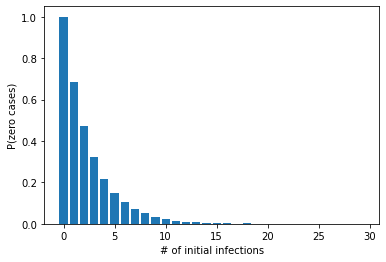

In [44]:
dieoutfig = plt.figure()
plt.bar([x for x in range(max_seed_infected)], height=[x[0]/iterations for x in categories_no_isolation["died_out"]])
plt.xlabel("# of initial infections")
plt.ylabel('P(zero cases)')

print([x[0]/iterations for x in categories_no_isolation["died_out"]])

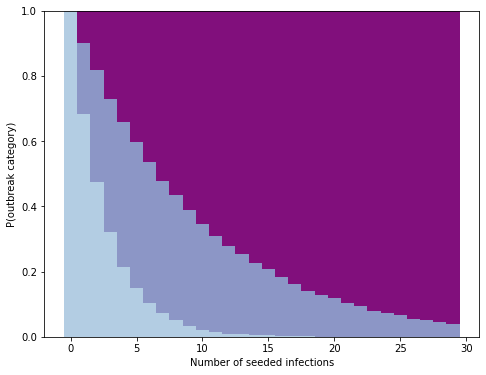

In [45]:
#print(categories)

colormap = ["#B3CDE3", "#8C96C6", "#810F7C"]
plt.figure(figsize=[6*1.3,6])
plt.bar([x for x in range(max_seed_infected)], height=[x[0]/iterations for x in categories_no_isolation["categories"]], 
color=colormap[0], width=1)
plt.bar([x for x in range(max_seed_infected)], height=[x[1]/iterations for x in categories_no_isolation["categories"]], bottom=[x[0]/iterations for x in categories_no_isolation["categories"]],
color=colormap[1], width=1)
plt.bar([x for x in range(max_seed_infected)], height=[x[2]/iterations for x in categories_no_isolation["categories"]], bottom=[(x[0]+x[1])/iterations for x in categories_no_isolation["categories"]], 
color=colormap[2], width=1)

plt.xlabel('Number of seeded infections')
plt.ylabel('P(outbreak category)')

plt.savefig('outbreak_categories.png', dpi=300)

In [46]:
#Critical number of seedings - first generation in isolation:
categories_all_isolation = get_seedings(in_isolation="all", max_infected=max_infected, max_seed_infected=max_seed_infected)

  0%|          | 0/30 [00:00<?, ?it/s]

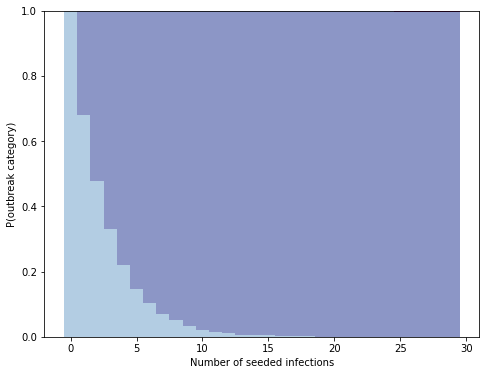

In [47]:
plt.figure(figsize=[6*1.3,6])
plt.bar([x for x in range(max_seed_infected)], height=[x[0]/iterations for x in categories_all_isolation["categories"]], 
color=colormap[0], width=1)
plt.bar([x for x in range(max_seed_infected)], height=[x[1]/iterations for x in categories_all_isolation["categories"]], bottom=[x[0]/iterations for x in categories_all_isolation["categories"]],
color=colormap[1], width=1)
plt.bar([x for x in range(max_seed_infected)], height=[x[2]/iterations for x in categories_all_isolation["categories"]], bottom=[(x[0]+x[1])/iterations for x in categories_all_isolation["categories"]], 
color=colormap[2], width=1)

plt.xlabel('Number of seeded infections')
plt.ylabel('P(outbreak category)')

plt.savefig('outbreak_categories_isolation.png', dpi=300)

0.714039

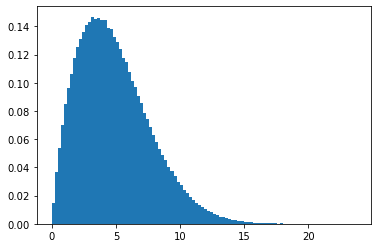

In [62]:
infection_time_dist = get_infection_times(1000000)

plot = plt.figure()
plot = plt.hist(infection_time_dist, bins=100, density=True)
len(infection_time_dist[infection_time_dist >=3])/len(infection_time_dist)

0.0       8
2.5     647
1.5     176
3.5    1835
4.5    3752
5.5    3565
0.5      17
dtype: int64
4.4804


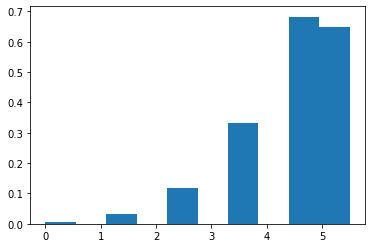

In [9]:
infection_days = np.zeros(10000)
for i in range(10000):
    ob = run_outbreak(1,10)
    infection_days[i] = ob[0]["infection_days"]

print(pd.Series(infection_days).value_counts(sort=False))
print(statistics.mean(infection_days))
plot = plt.figure()
plot = plt.hist(infection_days, density=True, rwidth=1)

In [55]:
transmission_potentials = [1.1, 1.5, 2]

seedings = []

for TRANSMISSION_POTENTIAL_MEAN in tqdm(transmission_potentials):
    seedings.append(get_seedings(in_isolation=None, max_infected=100, max_seed_infected=30, transmission_potential_mean=TRANSMISSION_POTENTIAL_MEAN))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [21]:
seedings_isolated = []
for TRANSMISSION_POTENTIAL_MEAN in tqdm(transmission_potentials):
    seedings_isolated.append(get_seedings(in_isolation="all", max_infected=100, max_seed_infected=30))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0, 0.5, 'TP=2.0')

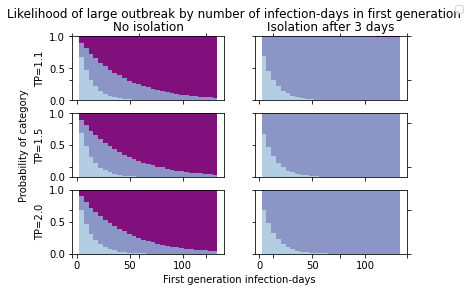

In [56]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)
fig.suptitle('Likelihood of large outbreak by number of infection-days in first generation')

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off")
ax.set_xlabel("First generation infection-days")
ax.set_ylabel("Probability of category", labelpad=20)

#plt.xlabel('First generation infection-days')
#fig.ylabel('Probability of category')

fig.legend(labels=["Zero cases", "<50 cases", ">50 cases"])

iterations=10000
colormap = ["#B3CDE3", "#8C96C6", "#810F7C"]
for i in range(3):
    axs[i, 0].bar([x*4.5 for x in range(1,30)], height=[x[0]/iterations for x in seedings[i]["categories"][1:]], 
color=colormap[0], width=4.5)
    axs[i, 0].bar([x*4.5 for x in range(1,30)], height=[x[1]/iterations for x in seedings[i]["categories"][1:]], bottom=[x[0]/iterations for x in seedings[i]["categories"][1:]],
color=colormap[1], width=4.5)
    axs[i, 0].bar([x*4.5 for x in range(1,30)], height=[x[2]/iterations for x in seedings[i]["categories"][1:]], bottom=[(x[0]+x[1])/iterations for x in seedings[i]["categories"][1:]], 
color=colormap[2], width=4.5)

    axs[i, 1].bar([x*4.5 for x in range(1,30)], height=[x[0]/iterations for x in seedings_isolated[i]["categories"][1:]], color=colormap[0], width=4.5)
    axs[i, 1].bar([x*4.5 for x in range(1,30)], height=[x[1]/iterations for x in seedings_isolated[i]["categories"][1:]], bottom=[x[0]/iterations for x in seedings_isolated[i]["categories"][1:]],
color=colormap[1], width=4.5)
    axs[i, 1].bar([x*4.5 for x in range(1,30)], height=[x[2]/iterations for x in seedings_isolated[i]["categories"][1:]], bottom=[(x[0]+x[1])/iterations for x in seedings_isolated[i]["categories"][1:]], 
color=colormap[2], width=4.5)


axs[0,0].set_title("No isolation")
axs[0,1].set_title("Isolation after 3 days")

axs[0,0].set_ylabel("TP=1.1")
axs[1,0].set_ylabel("TP=1.5")
axs[2,0].set_ylabel("TP=2.0")

In [141]:
fs = np.zeros(200)
for i in tqdm(range(200)):
    ob = run_outbreak(5, 30, np.zeros(5), in_isolation=None, max_infections = 100, transmission_potential_mean = 2)
    fs[i] = get_finalsize(ob)

print(statistics.mean(fs))

  0%|          | 0/200 [00:00<?, ?it/s]

282.255
